In [ ]:
!pip install keras_cv==0.5.0 wandb -q
!pip install -U keras-cv-attention-models -q
!pip install dataset

# **<span style="color:#088567;">Import Packages </span>**

In [ ]:
import os
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.python.client import device_lib

import keras_cv as kcv
from keras_cv import visualization
from keras_cv.models import ResNet18Backbone

from kaggle_secrets import UserSecretsClient
import wandb
from datetime import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:

user_secrets = UserSecretsClient()
wandb_api_key = os.getenv("WANDB_API_KEY")
wandb.login(key=wandb_api_key)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# **<span style="color:#088567;">Data Pipeline </span>**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

(x_train, y_train), held_out = keras.datasets.cifar10.load_data()
test_set, val_set = keras.utils.split_dataset(held_out, left_size=0.2)

170498071/170498071 [==============================] - 4s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/utils/dataset_utils.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(sample)


In [ ]:
def normalize(image, label, denorm=False):
    rescale = keras.layers.Rescaling(scale=1./255.)
    norms = keras.layers.Normalization(
        mean=[0.4914, 0.4822, 0.4465],
        variance=[np.square(0.2023), np.square(0.1994), np.square(0.2010)],
        invert=denorm,
        axis=-1,
    )

    if not denorm:
        image = rescale(image)
    return norms(image), label


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(buffer_size=8*BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)

(128, 32, 32, 3) (128, 1)


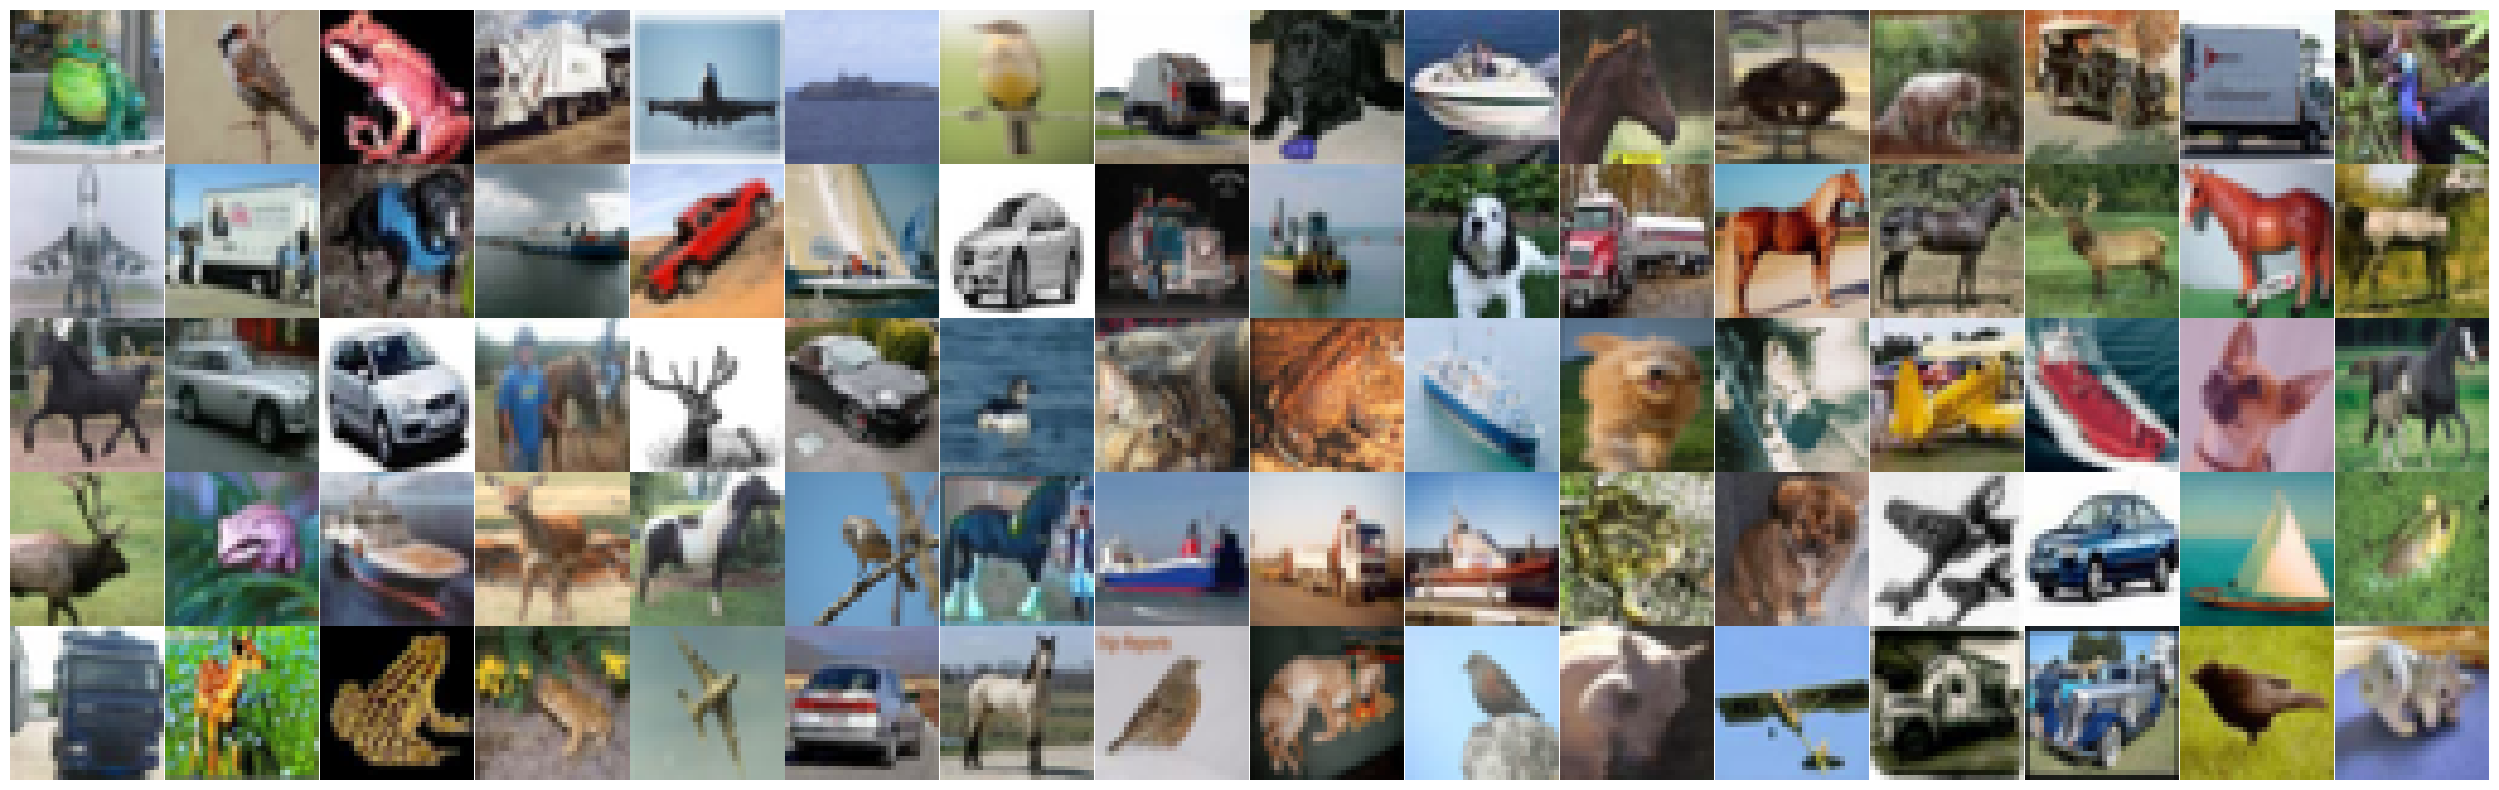

In [ ]:
temp_ds = train_ds.map(lambda x,y:normalize(x,y, denorm=True))
images, labels = next(iter(temp_ds))
print(images.shape, labels.shape)

visualization.plot_image_gallery(
    images, value_range=(0, 1), rows=5, cols=16
)


# **<span style="color:#088567;">CoAtNet </span>**

CoAtNets are a family of hybrid models based on the following
1. Depthwise convolution and self-attention can be naturally unified via simple relative attention

2. Vertically stacking convolution layers and attention layers in a principled way is surprisingly effective in improving generalization, capacity, and efficiency.


In [ ]:
from keras_cv_attention_models import coatnet
def get_model():
    model = keras.Sequential(
            [
                coatnet.CoAtNet0(num_classes=0,input_shape=(32,32,3),pretrained=None),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
    model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

    return model
    #with strategy.scope():




In [ ]:
model = get_model()
model.fit(train_ds, validation_data=val_ds, epochs=20)
model.save("coat_cifat10.keras", save_format="keras_v3")

Epoch 1/20
391/391 [==============================] - 108s 166ms/step - loss: 4.4709 - accuracy: 0.3907 - val_loss: 1.3653 - val_accuracy: 0.5182
Epoch 2/20
391/391 [==============================] - 26s 68ms/step - loss: 1.0675 - accuracy: 0.6237 - val_loss: 1.4303 - val_accuracy: 0.5605
Epoch 3/20
391/391 [==============================] - 26s 68ms/step - loss: 0.8359 - accuracy: 0.7105 - val_loss: 0.7902 - val_accuracy: 0.7255
Epoch 4/20
391/391 [==============================] - 26s 67ms/step - loss: 0.6900 - accuracy: 0.7611 - val_loss: 0.8587 - val_accuracy: 0.7135
Epoch 5/20
391/391 [==============================] - 27s 68ms/step - loss: 0.5801 - accuracy: 0.7986 - val_loss: 0.9577 - val_accuracy: 0.7297
Epoch 6/20
391/391 [==============================] - 27s 69ms/step - loss: 0.5002 - accuracy: 0.8280 - val_loss: 0.8364 - val_accuracy: 0.7517
Epoch 7/20
391/391 [==============================] - 26s 68ms/step - loss: 0.4574 - accuracy: 0.8431 - val_loss: 0.8218 - val_accurac

In [ ]:
print(f"Train set accuracy: {100.0 * model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model.evaluate(test_ds)[-1]:0.1f}%%")

391/391 [==============================] - 9s 24ms/step - loss: 0.0993 - accuracy: 0.9672
Train set accuracy: 96.7%%
16/16 [==============================] - 0s 12ms/step - loss: 1.0637 - accuracy: 0.7940
Test set accuracy: 79.4%%


# **<span style="color:#088567;">Unlearning By Retraining </span>**

In [ ]:
forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
int(forget_ds.cardinality()), int(retain_ds.cardinality())

(40, 352)

In [ ]:
def unlearning(net, retain, forget, validation):

    epochs = 20
    loss = losses.SparseCategoricalCrossentropy()
    metric = metrics.SparseCategoricalAccuracy(name='accuracy')
    sched = optimizers.schedules.CosineDecay(
            initial_learning_rate=0.1, decay_steps=retain.cardinality() * epochs
        )
    optim = optimizers.SGD(
            learning_rate=sched, momentum=0.9, weight_decay=5e-4
        )

        # compile the model
    net.compile(
            optimizer=optim,
            loss=loss,
            metrics=metric,
        )

    # training
    net.fit(retain,verbose=1, epochs=epochs)

    return net






In [ ]:
net = keras.models.load_model("/kaggle/working/coat_cifat10.keras")


model_ft = unlearning(net, retain_ds, forget_ds, test_ds)

Epoch 1/20
352/352 [==============================] - 51s 78ms/step - loss: nan - accuracy: 0.1069
Epoch 2/20
352/352 [==============================] - 26s 74ms/step - loss: nan - accuracy: 0.1000
Epoch 3/20
352/352 [==============================] - 26s 74ms/step - loss: nan - accuracy: 0.1000
Epoch 4/20
352/352 [==============================] - 26s 74ms/step - loss: nan - accuracy: 0.1000
Epoch 5/20
352/352 [==============================] - 26s 74ms/step - loss: nan - accuracy: 0.1000
Epoch 6/20
352/352 [==============================] - 26s 74ms/step - loss: nan - accuracy: 0.1000
Epoch 7/20
352/352 [==============================] - 26s 75ms/step - loss: nan - accuracy: 0.1000
Epoch 8/20
352/352 [==============================] - 26s 74ms/step - loss: nan - accuracy: 0.1000
Epoch 9/20
352/352 [==============================] - 26s 74ms/step - loss: nan - accuracy: 0.1000
Epoch 10/20
352/352 [==============================] - 26s 74ms/step - loss: nan - accuracy: 0.1000
Epoch 11/

In [ ]:
print(f"Retain set accuracy: {100.0 * model_ft.evaluate(retain_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model_ft.evaluate(test_ds)[-1]:0.1f}%%")
print(f"Forget set accuracy: {100.0 * model_ft.evaluate(forget_ds)[-1]:0.1f}%%")


352/352 [==============================] - 6s 16ms/step - loss: 1.0809 - accuracy: 0.6067
Retain set accuracy: 60.7%%
16/16 [==============================] - 0s 16ms/step - loss: 1.3018 - accuracy: 0.5320
Test set accuracy: 53.2%%
40/40 [==============================] - 1s 16ms/step - loss: 1.3142 - accuracy: 0.5274
Forget set accuracy: 52.7%%


# **<span style="color:#088567;">EfficientFormerV2 </span>**



In [ ]:
from keras_cv_attention_models import efficientformer
def get_model():
        model = keras.Sequential(
            [
                efficientformer.EfficientFormerV2S0(num_classes=0,input_shape=(32,32,3),pretrained=None),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
        model.summary()
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
        )

        return model

model = get_model()
model.fit(train_ds, validation_data=val_ds, epochs=20)
model.save("EfficientFormerV2S_cifat10.keras", save_format="keras_v3")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientformer_v2_s0 (Func  (None, 1, 1, 176)        3291792   
 tional)                                                         
                                                                 
 global_max_pooling2d_3 (Glo  (None, 176)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_3 (Dense)             (None, 10)                1770      
                                                                 
Total params: 3,293,562
Trainable params: 3,244,602
Non-trainable params: 48,960
_________________________________________________________________
Epoch 1/20
391/391 [==============================] - 103s 86ms/step - loss: 1.4862 - accuracy: 0.4820 - val_loss: 1.3250 - val_accuracy: 0.5354
Epoch 2/20
391/391 [======

In [ ]:
print(f"Train set accuracy: {100.0 * model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model.evaluate(test_ds)[-1]:0.1f}%%")

391/391 [==============================] - 9s 22ms/step - loss: 0.0935 - accuracy: 0.9663
Train set accuracy: 96.6%%
16/16 [==============================] - 0s 21ms/step - loss: 1.5302 - accuracy: 0.7185
Test set accuracy: 71.9%%


In [ ]:
forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
int(forget_ds.cardinality()), int(retain_ds.cardinality())

def unlearning2(net, retain, forget, validation):

        epochs = 20

        # loss, metric, scheduler, optimizer
        loss = losses.SparseCategoricalCrossentropy()
        metric = metrics.SparseCategoricalAccuracy(name='accuracy')
        sched = optimizers.schedules.CosineDecay(
            initial_learning_rate=0.1, decay_steps=retain.cardinality() * epochs
        )
        optim = optimizers.SGD(
            learning_rate=sched, momentum=0.9, weight_decay=5e-4
        )

        # compile the model
        net.compile(
            optimizer=optim,
            loss=loss,
            metrics=metric,
        )

    # training
        net.fit(retain, epochs=epochs)

        return net

In [ ]:
# load pre-trained model
net = keras.models.load_model("EfficientFormerV2S_cifat10.keras")


model_ft = unlearning2(net, retain_ds, forget_ds, test_ds)

Epoch 1/20
352/352 [==============================] - 61s 77ms/step - loss: 1.4423 - accuracy: 0.4959
Epoch 2/20
352/352 [==============================] - 27s 77ms/step - loss: 0.9252 - accuracy: 0.6705
Epoch 3/20
352/352 [==============================] - 27s 77ms/step - loss: 0.6795 - accuracy: 0.7594
Epoch 4/20
352/352 [==============================] - 27s 77ms/step - loss: 0.5276 - accuracy: 0.8139
Epoch 5/20
352/352 [==============================] - 27s 77ms/step - loss: 0.4367 - accuracy: 0.8436
Epoch 6/20
352/352 [==============================] - 27s 77ms/step - loss: 0.3548 - accuracy: 0.8733
Epoch 7/20
352/352 [==============================] - 27s 77ms/step - loss: 0.2795 - accuracy: 0.8992
Epoch 8/20
352/352 [==============================] - 27s 77ms/step - loss: 0.2128 - accuracy: 0.9247
Epoch 9/20
352/352 [==============================] - 27s 77ms/step - loss: 0.1581 - accuracy: 0.9432
Epoch 10/20
352/352 [==============================] - 27s 77ms/step - loss: 0.107

In [ ]:
print(f"Retain set accuracy: {100.0 * model_ft.evaluate(retain_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model_ft.evaluate(test_ds)[-1]:0.1f}%%")
print(f"Forget set accuracy: {100.0 * model_ft.evaluate(forget_ds)[-1]:0.1f}%%")


352/352 [==============================] - 9s 20ms/step - loss: 0.0024 - accuracy: 0.9997
Retain set accuracy: 100.0%%
16/16 [==============================] - 0s 21ms/step - loss: 1.8820 - accuracy: 0.7305
Test set accuracy: 73.0%%
40/40 [==============================] - 1s 27ms/step - loss: 1.2970 - accuracy: 0.7822
Forget set accuracy: 78.2%%


# **<span style="color:#088567;">ResNet-50 </span>**



In [ ]:
from keras.applications import ResNet50

def get_model():
    base_model = ResNet50(weights=None, include_top=False, input_shape=(32, 32, 3))
    model = keras.Sequential(
        [
            base_model,
            layers.GlobalMaxPooling2D(),
            layers.Dense(10, activation="softmax", dtype=tf.float32),
        ]
    )
    model.summary()
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=[metrics.SparseCategoricalAccuracy(name='accuracy')],
    )
    return model

model = get_model()
model.fit(train_ds, validation_data=val_ds, epochs=20)
model.save("ResNet18_cifar10.keras", save_format="keras_v3")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_max_pooling2d_4 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
391/391 [==============================] - 66s 61ms/step - loss: 1.8061 - accuracy: 0.3906 - val_loss: 1.4937 - val_accuracy: 0.4519
Epoch 2/20
391/391 [==============================] - 22s 55ms/step - loss: 1.5534 - accura

In [ ]:
print(f"Train set accuracy: {100.0 * model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model.evaluate(test_ds)[-1]:0.1f}%%")

391/391 [==============================] - 7s 17ms/step - loss: 0.4921 - accuracy: 0.8356
Train set accuracy: 83.6%%
16/16 [==============================] - 0s 17ms/step - loss: 0.8274 - accuracy: 0.7305
Test set accuracy: 73.0%%


In [ ]:
forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
int(forget_ds.cardinality()), int(retain_ds.cardinality())

def unlearning3(net, retain, forget, validation):

        epochs = 20

        loss = losses.SparseCategoricalCrossentropy()
        metric = metrics.SparseCategoricalAccuracy(name='accuracy')
        sched = optimizers.schedules.CosineDecay(
            initial_learning_rate=0.1, decay_steps=retain.cardinality() * epochs
        )
        optim = optimizers.SGD(
            learning_rate=sched, momentum=0.9, weight_decay=5e-4
        )

        # compile the model
        net.compile(
            optimizer=optim,
            loss=loss,
            metrics=metric,
        )

        # training
        net.fit(retain, epochs=epochs)

        return net

In [ ]:
# load pre-trained model
net = keras.models.load_model("ResNet18_cifar10.keras")


model_ft = unlearning3(net, retain_ds, forget_ds, test_ds)

Epoch 1/20
352/352 [==============================] - 36s 53ms/step - loss: 3.3521 - accuracy: 0.1994
Epoch 2/20
352/352 [==============================] - 19s 54ms/step - loss: 1.8757 - accuracy: 0.3070
Epoch 3/20
352/352 [==============================] - 19s 54ms/step - loss: 1.6197 - accuracy: 0.4034
Epoch 4/20
352/352 [==============================] - 19s 53ms/step - loss: 1.5022 - accuracy: 0.4474
Epoch 5/20
352/352 [==============================] - 19s 54ms/step - loss: 1.4207 - accuracy: 0.4836
Epoch 6/20
352/352 [==============================] - 19s 54ms/step - loss: 1.3531 - accuracy: 0.5102
Epoch 7/20
352/352 [==============================] - 19s 55ms/step - loss: 1.2924 - accuracy: 0.5321
Epoch 8/20
352/352 [==============================] - 19s 54ms/step - loss: 1.2319 - accuracy: 0.5557
Epoch 9/20
352/352 [==============================] - 19s 53ms/step - loss: 1.1770 - accuracy: 0.5763
Epoch 10/20
352/352 [==============================] - 19s 54ms/step - loss: 1.120

In [ ]:
print(f"Retain set accuracy: {100.0 * model_ft.evaluate(retain_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model_ft.evaluate(test_ds)[-1]:0.1f}%%")
print(f"Forget set accuracy: {100.0 * model_ft.evaluate(forget_ds)[-1]:0.1f}%%")


352/352 [==============================] - 7s 16ms/step - loss: 0.6361 - accuracy: 0.7792
Retain set accuracy: 77.9%%
16/16 [==============================] - 0s 16ms/step - loss: 1.4718 - accuracy: 0.5620
Test set accuracy: 56.2%%
40/40 [==============================] - 1s 16ms/step - loss: 1.4315 - accuracy: 0.5758
Forget set accuracy: 57.6%%
